In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv("data/서울시_상권_추정매출.csv")

print("=" * 70)
print("데이터 불러오기 완료")
print("=" * 70)
print(f"총 레코드 수: {len(df):,}개")
print(f"컬럼 수: {len(df.columns)}개")
print(f"\n데이터 미리보기:")
print(df.head())

데이터 불러오기 완료
총 레코드 수: 20개
컬럼 수: 13개

데이터 미리보기:
    상권_코드     상권_명    행정동 업종_대분류 업종_중분류  점포수     총매출   유동인구   주거인구   직장인구  \
0  100001   강남역 상권   강남역동     소매     잡화  122  415838  23575  12964  14284   
1  100002  홍대입구 상권  홍대입구동     소매    화장품  117  225203  29495  17023   4685   
2  100003    명동 상권    명동동    서비스     세탁   93  153355   8420  18568  22769   
3  100004  건대입구 상권  건대입구동     소매    화장품   71  199503   4747   1189  22118   
4  100005    잠실 상권    잠실동     음식     양식  130  578178  10838  15502  24777   

   평균_영업기간  신규점포수  폐업점포수  
0      2.1      3      6  
1      1.4      8      3  
2      4.7      9      0  
3      5.3      7      3  
4      7.6      2      1  


In [2]:

import pandas as pd
import numpy as np

# 랜덤 시드 고정 (재현 가능)
np.random.seed(42)

# 상권, 업종 정보
districts = [
    "강남역", "홍대입구", "명동", "건대입구", "잠실", 
    "이태원", "신촌", "압구정", "사당", "노량진",
    "종로3가", "성수", "선릉", "구로디지털", "수유",
    "왕십리", "천호", "상봉", "신림", "목동"
]

categories = ["음식", "서비스", "소매"]
subcategories = {
    "음식": ["한식", "중식", "양식", "일식", "분식"],
    "서비스": ["미용", "세탁", "수리", "숙박", "학원"],
    "소매": ["편의점", "의류", "화장품", "잡화", "서점"]
}

# 데이터 생성
data = []
for i, district in enumerate(districts, start=1):
    main_cat = np.random.choice(categories)
    sub_cat = np.random.choice(subcategories[main_cat])
    stores = np.random.randint(30, 150)
    sales = np.random.randint(50000, 600000)
    floating = np.random.randint(2000, 30000)
    residential = np.random.randint(1000, 20000)
    office = np.random.randint(3000, 40000)
    years = round(np.random.uniform(1, 8), 1)
    new_stores = np.random.randint(1, 10)
    closed_stores = np.random.randint(0, 8)
    
    data.append([
        100000 + i, f"{district} 상권", f"{district}동", main_cat, sub_cat,
        stores, sales, floating, residential, office, years, new_stores, closed_stores
    ])

# 컬럼 정의
columns = [
    "상권_코드", "상권_명", "행정동", "업종_대분류", "업종_중분류",
    "점포수", "총매출", "유동인구", "주거인구", "직장인구",
    "평균_영업기간", "신규점포수", "폐업점포수"
]

# DataFrame 생성
df = pd.DataFrame(data, columns=columns)

# CSV 파일로 저장
save_path = "서울시_상권_추정매출.csv"
df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"✅ CSV 파일 생성 완료: {save_path}")
print(df.head())


✅ CSV 파일 생성 완료: 서울시_상권_추정매출.csv
    상권_코드     상권_명    행정동 업종_대분류 업종_중분류  점포수     총매출   유동인구   주거인구   직장인구  \
0  100001   강남역 상권   강남역동     소매     잡화  122  415838  23575  12964  14284   
1  100002  홍대입구 상권  홍대입구동     소매    화장품  117  225203  29495  17023   4685   
2  100003    명동 상권    명동동    서비스     세탁   93  153355   8420  18568  22769   
3  100004  건대입구 상권  건대입구동     소매    화장품   71  199503   4747   1189  22118   
4  100005    잠실 상권    잠실동     음식     양식  130  578178  10838  15502  24777   

   평균_영업기간  신규점포수  폐업점포수  
0      2.1      3      6  
1      1.4      8      3  
2      4.7      9      0  
3      5.3      7      3  
4      7.6      2      1  


In [3]:
# 데이터 품질 확인
# 1. 결측치 확인
(df.isna().sum())[df.isna().sum() > 0]
# 2. 중복데이터 확인
df[df.duplicated()]
# 3. 데이터 타입 확인
pd.DataFrame(df.dtypes).T
# 4. 기술통계
df.describe(include=object)

,상권_명,행정동,업종_대분류,업종_중분류
count,20,20,20,20
unique,20,20,3,9
top,강남역 상권,강남역동,음식,화장품
freq,1,1,9,4


In [4]:
# 데이터 전처리
    # 결측치 확인 및 제거 또는 대처
    # 이상치 제거  IQR = Q3- Q1      [Q1 - 1.5xIQR   ~~~    Q3 + 1.5xIQR]
    # 파생변수 생성
        # 평일 총 매출,  주말 총 매출, 평일과주말비율
        # 날자가 있는경우 주말과 공휴일 여부  0 / 1
        # 비율, 점유율, 할인율 등.... 기존데이터로 새로운 피처를 생성

In [5]:
# 이상치 여부 확인  월 매출금액
# quantile(0.25)
# boxplot
seoul_df = pd.read_csv('서울시 상권분석서비스(추정매출-상권)_2024년.csv')
seoul_df.columns = seoul_df.columns.str.replace('_',"")
seoul_df.columns = seoul_df.columns.str.replace('연령대10매출금액','10대매출금액')
seoul_df.columns = seoul_df.columns.str.replace('연령대20매출금액','20대매출금액')
seoul_df.columns = seoul_df.columns.str.replace('연령대30매출금액','30대매출금액')
seoul_df.columns = seoul_df.columns.str.replace('연령대40매출금액','40대매출금액')
seoul_df.columns = seoul_df.columns.str.replace('연령대50매출금액','50대매출금액')
seoul_df.columns = seoul_df.columns.str.replace('연령대60이상매출금액','60대이상매출금액')


In [6]:
seoul_df.to_csv('서울시 상권분석서비스(추정매출-상권)_2024년.csv',encoding='utf-8')

In [7]:
# https://drive.google.com/file/d/125o7TvA2A-1xbJniSBdWTzl-3PEGv_bT/view?usp=sharing
import requests
url = "https://drive.google.com/uc?export=download&id=125o7TvA2A-1xbJniSBdWTzl-3PEGv_bT"
r = requests.get(url)
open('seoul.csv', 'wb').write(r.content)

32628175

In [8]:
df = pd.read_csv('seoul.csv')
df.columns = df.columns.str.replace('당월매출금액','월매출금액')
df.columns = df.columns.str.replace('당월매출건수','월매출건수')

<Axes: ylabel='월매출금액'>

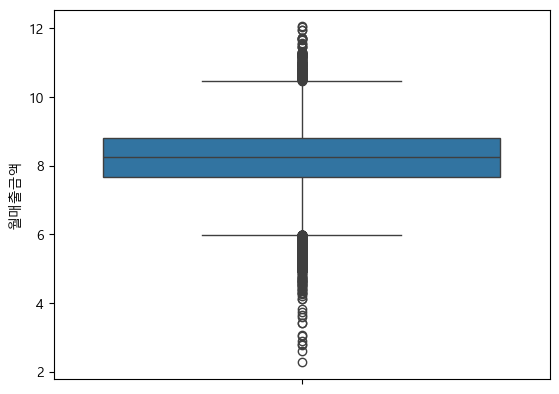

In [9]:
import seaborn as sns
np.log10(df['월매출금액'])
sns.boxplot(df, y=np.log10(df['월매출금액']))


In [10]:
# IQR
Q1 = df['월매출금액'].quantile(0.25)
Q3 = df['월매출금액'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['월매출금액'] < lower_bound) | 
                      (df['월매출금액'] > upper_bound)]

print(f"\n이상치: {len(outliers)}개 ({len(outliers)/len(df)*100:.1f}%)")
print("이상치 처리 방법 선택:")
print("  1) 제거: 분석에서 제외")
print("  2) 유지: 특별한 케이스로 별도 분석")
print("  → 프로젝트 목적에 따라 결정")


이상치: 10689개 (12.3%)
이상치 처리 방법 선택:
  1) 제거: 분석에서 제외
  2) 유지: 특별한 케이스로 별도 분석
  → 프로젝트 목적에 따라 결정


In [11]:
print(set(df['상권코드명'].unique().tolist()))

{'양천향교역 5번', '월곡역', '군자역 4번', '지향초등학교', '신대방역 1번', '아현시장', '대학로(혜화역)', '동대부고', '개봉1동주민센터', '아차산역 1번', '쌍문초등학교', '길동복조리시장', '월정로시장', '광산사거리', '쌍문역둘리상점가', '인사동', '상도약수골목형상점가', '상도역 5번', '연희지하차도', '신월1파출소', '암사종합시장', '우장산힐스테이트', '능동로골목시장', '경복아파트교차로', '경춘선숲길 우측', '영등포시장역 4번', '송천동주민센터', '상계2동주민센터', '광나루역 1번', '면목역 3번', '선정릉역 4번', '백련산해모로아파트', '강북중학교', '창신1동주민센터', '논현종합시장', '석촌고분역 3번', '신림중앙시장(조원동 펭귄시장)', '부암동주민센터', '성신여대입구역 4번', '성수대교남단', '관악신사시장', '천왕역 3번(오류2동주민센터, 서울오류남초등학교)', '장훈고등학교', '전곡마을마당공원', '도봉역 3번', '영등포시장기계공구상가', '대흥역 3번', '경신고등학교', 'KB국민은행 종암동지점', '응암동우체국', '한양대앞상점가(한양시장, 왕십리맛골목)', '암사역 4번(삼성광나루아파트)', '무너미어린이공원', '선일여고', '논현2동주민센터', '영락고등학교', '영등포동성당', '까치산시장', '홍남교남측', '이촌동점보아파트', '유엔빌리지길', '한성대입구역 5번', '신정3동 골목시장', '등촌역', '삼익패션타운(남대문시장)', '고대앞사거리', '종로구청', '동묘시장(동묘벼룩시장)', '장평중학교', '보문역 5번', '무학봉상점가', '서울과학기술대', '중랑노인종합복지관', '영신초등학교', '강동구립 천호도서관', '아래방죽마을공원(율현초등학교)', '등마루시장', '을지로4가역', '삼각지역', 'KT구로지사', '성신여대운정그린캠퍼스', '개봉중앙시장', '마포역', '영등포역지하도상점가', '증산골목시장', '고덕동성당', '중앙대학교

In [12]:
%pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [13]:
from geopy.geocoders import Nominatim
def get_name(x):
    try:
        geolocator = Nominatim(user_agent="my_app")
        location = geolocator.geocode(x)
        return "".join(location.address.split(',')[-3:-6:-1])
    except:
        return np.nan
get_name('이북5도청사')

' 서울특별시 종로구 평창동'

In [14]:
df.shape

(87179, 56)

In [ ]:
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import os

API_KEY = "KakaoAK 자신의 키"
API_URL = "https://dapi.kakao.com/v2/local/search/keyword.json"
HEADERS = {"Authorization": API_KEY}

def geocode(place_name, retry=3):
    params = {"query": place_name}
    for i in range(retry):
        try:
            resp = requests.get(API_URL, headers=HEADERS, params=params, timeout=5)
            data = resp.json()
            if data['documents']:
                doc = data['documents'][0]
                return {"상권명": place_name,
                        "address_name": doc.get('address_name', ''),
                        "x": doc.get('x', None),
                        "y": doc.get('y', None)}
            else:
                return {"상권명": place_name, "address_name": None, "x": None, "y": None}
        except:
            time.sleep(0.5)
    return {"상권명": place_name, "address_name": None, "x": None, "y": None}

# 상권명 리스트
places = df['상권코드명'].unique().tolist()

# 캐시 로드
cache_file = "geocode_cache.csv"
results = []
if os.path.exists(cache_file):
    cached_df = pd.read_csv(cache_file)
    cached_places = cached_df['상권명'].tolist()
    places = [p for p in places if p not in cached_places]
    results.extend(cached_df.to_dict(orient='records'))

# 병렬 처리
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(geocode, p): p for p in places}
    for future in as_completed(futures):
        results.append(future.result())
        time.sleep(0.05)  # 호출 간 간격

# 결과 저장
df_results = pd.DataFrame(results)
df_results.to_csv(cache_file, index=False, encoding="utf-8-sig")
print("✅ 완료:", len(df_results), "건 처리됨")


✅ 완료: 1581 건 처리됨


In [ ]:
df_results

,Unnamed: 0,기준년분기코드,상권구분코드,상권구분코드명,상권코드,상권코드명,서비스업종코드,서비스업종코드명,월매출금액,월매출건수,...,시간대건수~21매출건수,시간대건수~24매출건수,남성매출건수,여성매출건수,연령대10매출건수,연령대20매출건수,연령대30매출건수,연령대40매출건수,연령대50매출건수,연령대60이상매출건수
0,0,20241,A,골목상권,3110001,이북5도청사,CS100001,한식음식점,385150643,11743,...,3496,52,6023,4281,26,508,935,1997,3135,3704
1,1,20241,A,골목상권,3110001,이북5도청사,CS100009,호프-간이주점,11026440,214,...,123,39,103,78,0,0,0,32,55,95
2,2,20241,A,골목상권,3110001,이북5도청사,CS200001,일반교습학원,52047765,224,...,112,8,48,176,0,0,8,152,64,0
3,3,20241,A,골목상권,3110002,독립문역 1번,CS100001,한식음식점,582522265,20630,...,5358,487,11887,7589,17,914,2595,3483,5408,7049
4,4,20241,A,골목상권,3110002,독립문역 1번,CS100005,제과점,446525280,40242,...,11472,2634,16005,22755,329,3589,7446,8867,9543,8986


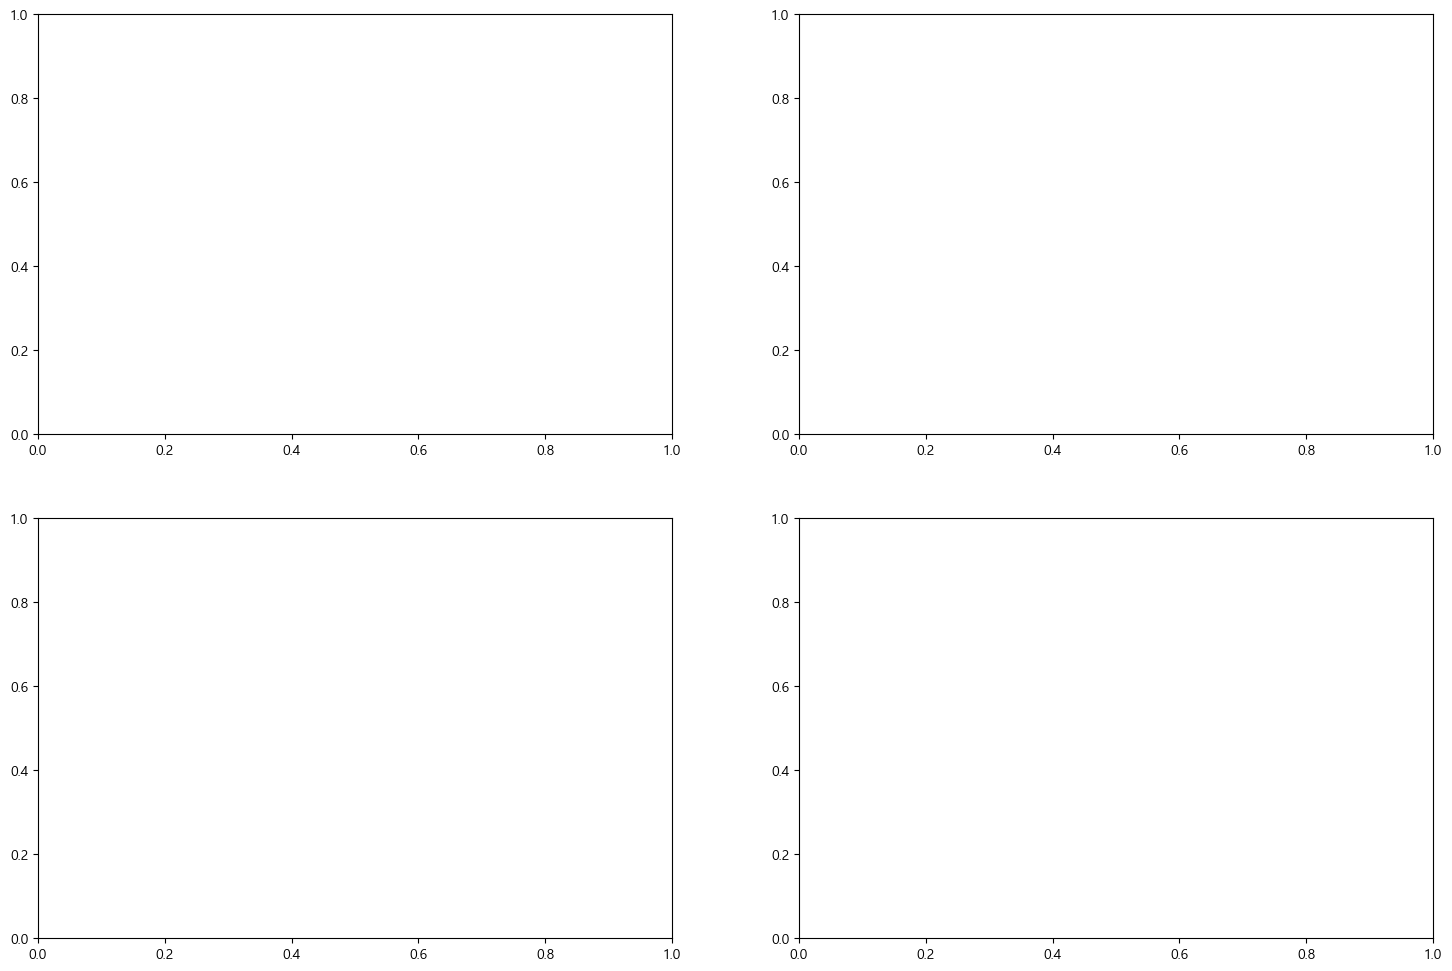

In [ ]:
# 1. 상권코드명별 매장 수
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
# 상권코드명
# 1-1. 구별 매장 수
district_counts = df_project['행정구역명'].value_counts().head(10)
axes[0, 0].barh(range(len(district_counts)), district_counts.values, color='skyblue')
axes[0, 0].set_yticks(range(len(district_counts)))
axes[0, 0].set_yticklabels(district_counts.index)
axes[0, 0].set_title(f'{target_industry} - 구별 매장 수 Top 10', fontweight='bold')
axes[0, 0].set_xlabel('매장 수')
axes[0, 0].grid(axis='x', alpha=0.3)